# Task 3: Shallow Neural Networks Equivalence to Gaussian Processes

In [208]:
import jax.numpy as jnp
from jax import random
from jax import jit, grad
import neural_tangents as nt
from neural_tangents import stax
import numpy as np
from src.visualizations.evaluation import plot_confusion_matrix, plot_classification_metric_summary
from src.evaluation.model_evaluation import get_classification_metric_summary
from src.data.data_helpers import load_mnist
from tensorflow.keras import layers, models

key = random.PRNGKey(10)

## Data Preparation

Here we prepare a part of the MNIST due to the computational limitations of GPs. We will use 1000 images for training, and 100 for testing.
The class will be one-hot encoded

In [ ]:
train_points = 1000
test_points = 100

In [196]:
train_xs, train_ys, _, _, test_xs, test_ys = load_mnist(validation_size=0, OHE=True)

train_xs, train_ys = train_xs[:train_points], train_ys[:train_points]
test_xs, test_ys = test_xs[:test_points], test_ys[:test_points]

train_xs = train_xs.reshape(train_points, -1)
test_xs = test_xs.reshape(test_points, -1)

train = (train_xs, train_ys)
test = (test_xs, test_ys)
test_ys_class = np.argmax(test_ys, axis=1)

## Single Layer Network

We will first define a 1-hidden layer neural network that is close enough to "infinite width". This network will have a fully-connected hidden layer with 1000 neurons followed by a relu activation. The output layer is of size 10, corresponding to the 10 classes, followed by a sigmoid. The choice of using sigmoid coupled with MSE error in multi-class classification problem was due to the limitations of the library extracting the equivalent GP. The theory (and thus the current libraries) is lacking insight on solving classification problems with such methods.

In [206]:
model = models.Sequential([
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Train the model

model.fit(train_xs, train_ys, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_xs, test_ys)


Epoch 1/10
32/32 [==============================] - 1s 8ms/step - loss: 0.0780 - accuracy: 0.4960
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0358 - accuracy: 0.7500
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.8770
Epoch 4/10
32/32 [==============================] - 0s 11ms/step - loss: 0.0148 - accuracy: 0.9310
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0107 - accuracy: 0.9520
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0081 - accuracy: 0.9650
Epoch 7/10
32/32 [==============================] - 0s 11ms/step - loss: 0.0064 - accuracy: 0.9750
Epoch 8/10
32/32 [==============================] - 0s 12ms/step - loss: 0.0049 - accuracy: 0.9820
Epoch 9/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 0.9840
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0135 - accuracy: 0.9400


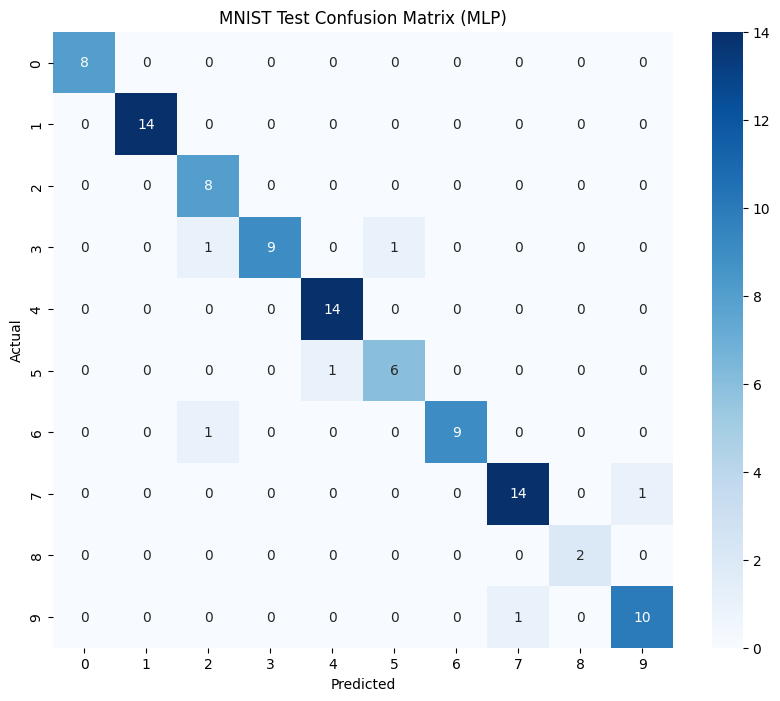

In [207]:
probs = model(test_xs)
y_test_pred_class_finite = np.argmax(probs, axis=1)

plot_confusion_matrix(test_ys_class, y_test_pred_class_finite, "MNIST Test Single Layer Neural Network (100 samples)")

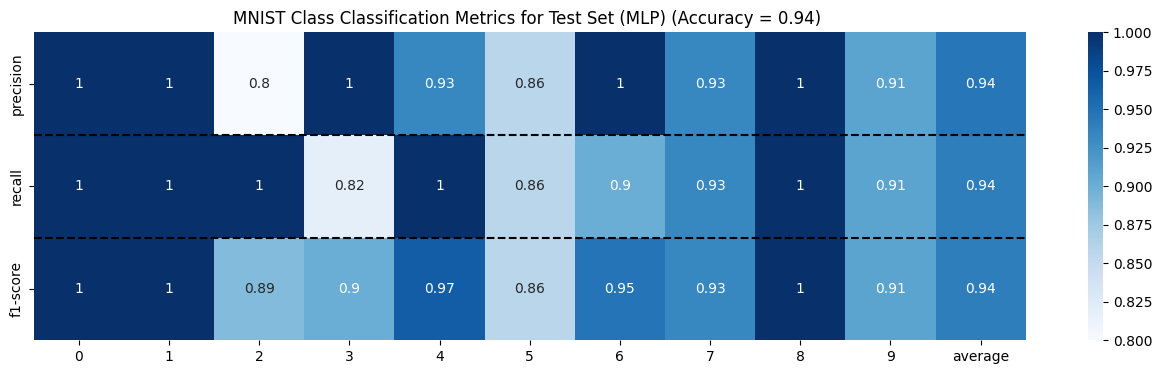

In [209]:
class_metrics, accuracy = get_classification_metric_summary(test_ys_class, y_test_pred_class_finite)
plot_classification_metric_summary(class_metrics, f"MNIST Test Classification Metrics on Single Layer Neural Network (Accuracy = {accuracy:.2f}) ")

## Equivalent Gaussian Process

According to the theory, the outputs of this network are independent and form a multivariate gaussian distribution due to the weights and biases being normally distributed, and the fact that the central limmit theorem takes effect the wider the hidden layer. This makes the previous network to behave like a gaussian process. Therefore, the equivalent GP should yield similar results as the network. In this section we attempt to extract the equivalent GP.

To do this, we use google's neural-tangent library due to the complicated computations associated with extracting the kernel matrix from the network, in addition to training this GP, and getting the posterior kernel matrix

Below we difine the same architecture again using the neural-tangents library.

In [210]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(1000), stax.Relu(),
    stax.Dense(10),
    stax.Sigmoid_like()
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

We can sample from the prior distribution before training the GP. 

In [198]:
key, net_key = random.split(key)
_, params = init_fn(net_key, (-1, 28 * 28))
prior_preds = apply_fn(params, test_xs)

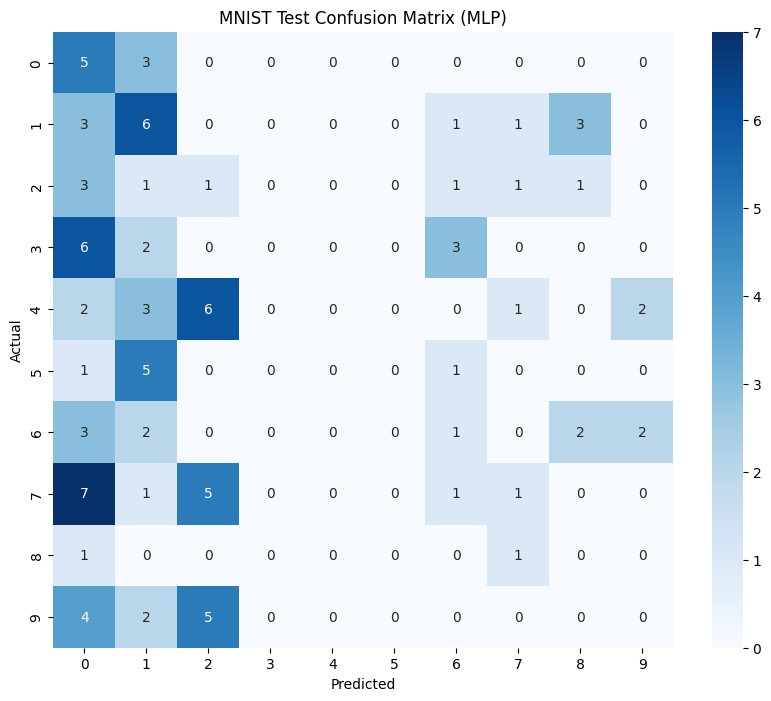

In [199]:
y_test_pred_class_prior = np.argmax(prior_preds, axis=1)
plot_confusion_matrix(test_ys_class, y_test_pred_class_prior, "MNIST Test Equivalent GP Prior (100 samples)")

In [ ]:
class_metrics, accuracy = get_classification_metric_summary(test_ys_class, y_test_pred_class_prior)
plot_classification_metric_summary(class_metrics, f"MNIST Test Classification Metrics for Test SetEquivalent GP on Prior (Accuracy = {accuracy:.2f}) ")

Next, we will obtain the kernel of the trained GP and compare the predicted means to the test targets

In [211]:
# we train the GP using gradient descent
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs,
                                                      train_ys, diag_reg=1e-4)


ntk_mean, ntk_covariance = predict_fn(x_test=test_xs, get='ntk',
                                      compute_cov=True)

ntk_mean = jnp.reshape(ntk_mean, (-1,10))
ntk_std = jnp.sqrt(jnp.diag(ntk_covariance))

In [212]:
y_test_pred_class = np.argmax(ntk_mean, axis=1)

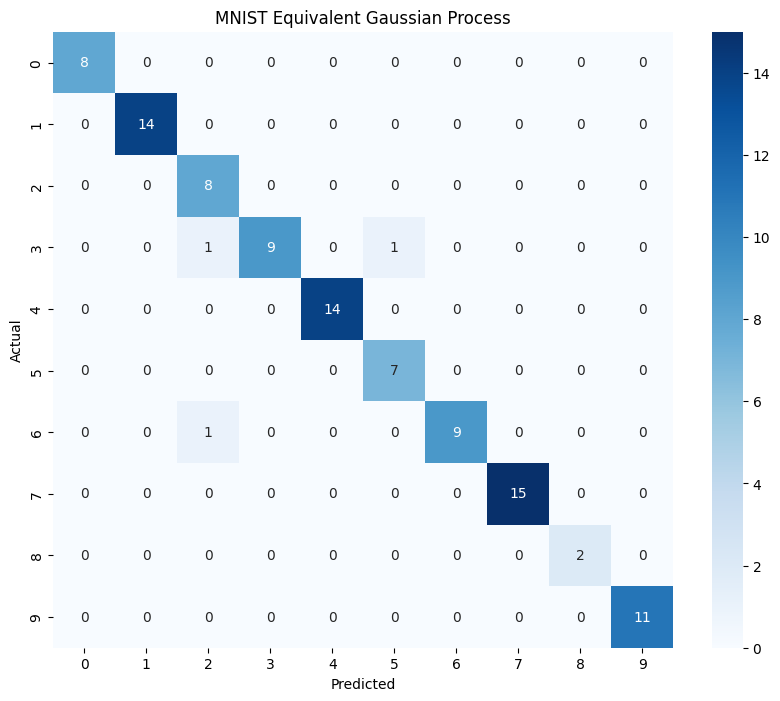

In [213]:
plot_confusion_matrix(test_ys_class, y_test_pred_class, "MNIST Equivalent Gaussian Process (100 samples)")

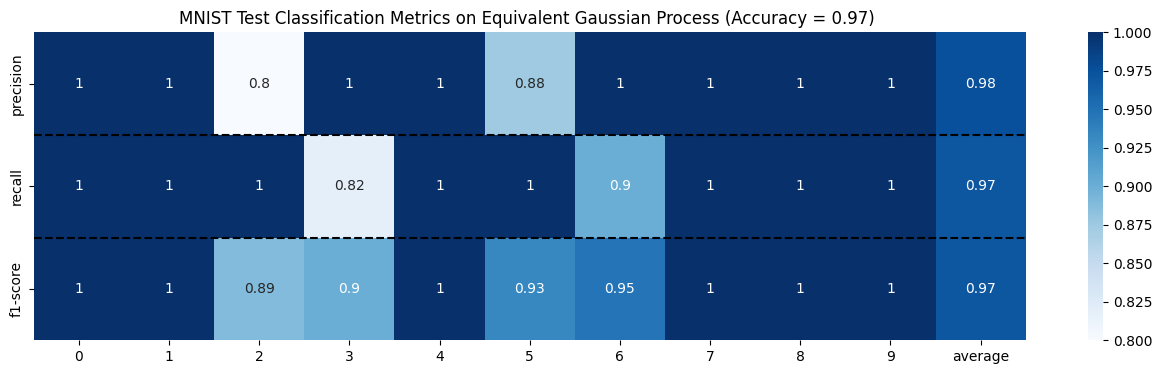

In [214]:
class_metrics, accuracy = get_classification_metric_summary(test_ys_class, y_test_pred_class)
plot_classification_metric_summary(class_metrics, f"MNIST Test Classification Metrics on Equivalent Gaussian Process (Accuracy = {accuracy:.2f}) ")

We can notice from comparing the metrics of the GP to the metrics of the neural network that the metrics of the classes are almost identical (eg. class 2 and 3). However, they are not an exact match. This can be attributed to the fact that we can never truly have an infinitely-wide neural network, but we can try to get close.